In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
from utils import data_util
from utils import vectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)  # show all columns
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

Initialized PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
data = pd.read_csv("../data/data_processed.csv")
#shuffle
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_train, data_test = train_test_split(data, test_size=0.7, stratify=data['label'], shuffle=True, random_state=42)
data.groupby('label').aggregate('count'), data_train.groupby('label').aggregate('count'), data_test.groupby('label').aggregate('count')

(          url
 label        
 bad     75642
 good   344821,
           url
 label        
 bad     22693
 good   103446,
           url
 label        
 bad     52949
 good   241375)

In [4]:
word_vectorizer = vectorization.get_word_vectorizer_v2(data_train['url'])
LW = len(word_vectorizer.vocabulary_)
print('Word vocabulary size:', LW)

C:\Users\szt\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Word vocabulary size: 500


In [5]:
dataset_train = data_util.create_dataset_generator(None, word_vectorizer, data_train).shuffle(10000).prefetch(10000)
dataset_test = data_util.create_dataset_generator(None, word_vectorizer, data_test).shuffle(10000).prefetch(10000)
print('Train:', dataset_train.element_spec, '\nTest:', dataset_test.element_spec)

Train: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Test: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 16)      8032        word[0][0]                       
__________________________________________________________________________________________________
word_conv_3 (Conv1D)            (None, 200, 32)      1568        embedding[0][0]                  
__________________________________________________________________________________________________
word_conv_5 (Conv1D)            (None, 200, 32)      2592        embedding[0][0]                  
______________________________________________________________________________________________

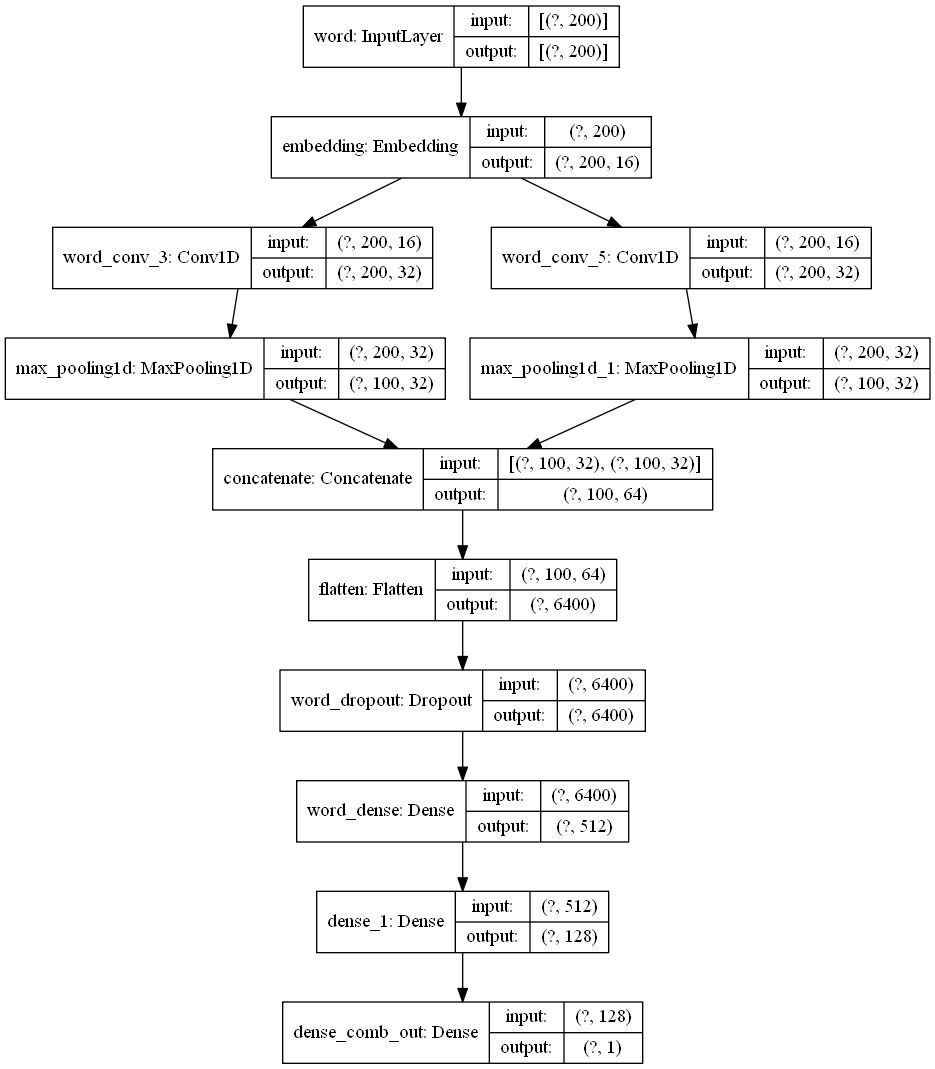

In [6]:
def create_conv_subnet(input_layer, conv_kernel_sizes, prefix=''):
    convolutions = list()
    for kernel_size in conv_kernel_sizes:
        x = k.layers.Conv1D(
            filters=32,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            name=f'{prefix}_conv_{kernel_size}'
        )(input_layer)
        x = k.layers.MaxPool1D()(x)
        convolutions.append(x)

    x = k.layers.concatenate(convolutions, axis=2)
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'{prefix}_dropout')(x)
    x = k.layers.Dense(512, name=f'{prefix}_dense', activation='relu')(x)
    return x

def create_url_net(input_length, emb_dim, conv_kernel_sizes):
    word_input = k.layers.Input(shape=[input_length], name='word')

    x = create_conv_subnet(
        k.layers.Embedding(2+LW, emb_dim, mask_zero=True)(word_input),
        conv_kernel_sizes,
        'word'
    )

    x = k.layers.Dense(128, activation='relu', name='dense_1')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[word_input], outputs=[x])
    return model

cnn_word_model = create_url_net(
    input_length=200,
    emb_dim=16,
    conv_kernel_sizes=[3,5]
)
cnn_word_model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
cnn_word_model.summary()
k.utils.plot_model(cnn_word_model, show_shapes=True)

In [7]:
bs=256

cnn_word_model.fit(
    dataset_train.batch(bs),
    epochs=100,
    validation_data=dataset_test.batch(bs),
    callbacks=[
        # k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./cnn_word_checkpoints', verbose=0)
    ],
)

    493/Unknown - 50s 100ms/step - loss: 0.3692 - binary_accuracy: 0.8496WARNING:tensorflow:From C:\Users\szt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./cnn_word_checkpoints\assets
493/493 [==============================] - 160s 325ms/step - loss: 0.3692 - binary_accuracy: 0.8496 - val_loss: 0.2165 - val_binary_accuracy: 0.9100


In [8]:
cnn_word_model.save('cnn_word_level')

INFO:tensorflow:Assets written to: cnn_word_level\assets
